# AWS Costs

In [1]:
from collections import defaultdict

import pandas as pd
!pip install tabulate -q
!pip install pandas>=1.0.0 -q

plt.tight_layout()

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


<Figure size 432x288 with 0 Axes>

## Instances 

Includes the costs for the EC2 instances plus other costs.

Raw data:

In [2]:
inst = pd.read_csv('./data/instance-costs.csv', parse_dates=True)
inst.head()

,InstanceType,m5.16xlarge($),p3.2xlarge($),c5.4xlarge($),p2.xlarge($),t3.xlarge($),c5.large($),t2.large($),t2.nano($),t2.micro($),No Instance Type($),Total cost ($)
0,Instance Type Total,1309.716100,237.380690,56.679688,25.656995,0.91056,0.450296,0.223631,0.000138,0.0,1124.806809,2755.824907
1,1/08/19,NaN,124.743427,14.217182,1.317897,0.91056,NaN,0.223631,NaN,NaN,237.268823,378.681520
2,1/09/19,NaN,21.955703,NaN,NaN,NaN,NaN,NaN,0.000138,0.0,425.017953,446.973794
3,1/10/19,90.876581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.159211,153.035791
4,1/11/19,585.423596,NaN,42.025574,NaN,NaN,NaN,NaN,NaN,0.0,146.832044,774.281215


Cleaning
- EC2 costs = Compute
- No instance type = Storage + Other

In [3]:
inst = pd.read_csv('./data/instance-costs.csv', parse_dates=True)
inst.index = inst.loc[:, 'InstanceType']
inst.index.name = 'month'
inst = inst.drop('Instance Type Total', axis=0) # total row drop
inst.loc[:, 'Storage + Other Total [$]'] = inst.loc[:, 'No Instance Type($)']
inst = inst.drop(
    ['InstanceType', 'No Instance Type($)', 'Total cost ($)'],
    axis=1
)
inst.loc[:, 'Compute Total [$]'] = inst.iloc[:, :-1].sum(axis=1)
inst.loc[:, 'Total [$]'] = inst.iloc[:, -2:].sum(axis=1)

inst = inst.fillna(0)

inst

,m5.16xlarge($),p3.2xlarge($),c5.4xlarge($),p2.xlarge($),t3.xlarge($),c5.large($),t2.large($),t2.nano($),t2.micro($),Storage + Other Total [$],Compute Total [$],Total [$]
month,,,,,,,,,,,,
1/08/19,0.000000,124.743427,14.217182,1.317897,0.91056,0.000000,0.223631,0.000000,0.0,237.268823,141.412697,378.681520
1/09/19,0.000000,21.955703,0.000000,0.000000,0.00000,0.000000,0.000000,0.000138,0.0,425.017953,21.955841,446.973794
1/10/19,90.876581,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,62.159211,90.876581,153.035791
1/11/19,585.423596,0.000000,42.025574,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,146.832044,627.449171,774.281215
1/12/19,633.415923,90.681560,0.436931,24.339099,0.00000,0.450296,0.000000,0.000000,0.0,252.712370,749.323808,1002.036178
1/01/20,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.816409,0.000000,0.816409


The total costs for the project:

In [4]:
summary = inst.sum(axis=0).to_frame()
summary.columns = ['Cost [$]']
summary.index = [str(i)[:-3] for i in summary.index]
summary

,Cost [$]
m5.16xlarge,1309.716100
p3.2xlarge,237.380690
c5.4xlarge,56.679688
p2.xlarge,25.656995
t3.xlarge,0.910560
c5.large,0.450296
t2.large,0.223631
t2.nano,0.000138
t2.micro,0.000000
Storage + Other Total,1124.806809


Metadata on the EC2 instances (number of CPU etc):

In [5]:
metadata = pd.DataFrame({
    'm5.16xlarge': ['controller', 64, 256, 0],
    'p3.2xlarge': ['vae-and-memory', 8, 61, 16],
    'p2.xlarge': ['vae-and-memory', 4, 61, 12],
    
    'c5.2xlarge': ['data', 8, 16, 0],
    'c5.4xlarge': ['data', 16, 32, 0],
    
    'm4.16xlarge': ['sample-latent-stats', 16, 64, 0],
    
    't2.xlarge': ['misc', 4, 16, 0]

}).T

metadata.columns = ['component', 'cpu [num]', 'memory [GB]', 'gpu [GB]']

metadata.head()

,component,cpu [num],memory [GB],gpu [GB]
m5.16xlarge,controller,64,256,0
p3.2xlarge,vae-and-memory,8,61,16
p2.xlarge,vae-and-memory,4,61,12
c5.2xlarge,data,8,16,0
c5.4xlarge,data,16,32,0


In [6]:
out = pd.concat([metadata, summary], axis=1, sort=False).sort_values('Cost [$]', ascending=False)

out = out.dropna(axis=0)

print(out.round(2))
print('')
out.round(2).to_markdown()

                  component cpu [num] memory [GB] gpu [GB]  Cost [$]
m5.16xlarge      controller        64         256        0   1309.72
p3.2xlarge   vae-and-memory         8          61       16    237.38
c5.4xlarge             data        16          32        0     56.68
p2.xlarge    vae-and-memory         4          61       12     25.66



'|             | component      |   cpu [num] |   memory [GB] |   gpu [GB] |   Cost [$] |\n|:------------|:---------------|------------:|--------------:|-----------:|-----------:|\n| m5.16xlarge | controller     |          64 |           256 |          0 |    1309.72 |\n| p3.2xlarge  | vae-and-memory |           8 |            61 |         16 |     237.38 |\n| c5.4xlarge  | data           |          16 |            32 |          0 |      56.68 |\n| p2.xlarge   | vae-and-memory |           4 |            61 |         12 |      25.66 |'

In [7]:
out = out.groupby('component').sum().sort_values('Cost [$]', ascending=False)

out = out.loc[:, 'Cost [$]'].to_frame()
out.loc[:, 'Cost [%]'] = 100 * out.loc[:, 'Cost [$]'] / sum(out.loc[:, 'Cost [$]'])
out.loc['total', :] = out.sum(axis=0)

print(out.round(2))
print('')
print(out.round(2).to_markdown())

                Cost [$]  Cost [%]
component                         
controller       1309.72     80.38
vae-and-memory    263.04     16.14
data               56.68      3.48
total            1629.43    100.00

| component      |   Cost [$] |   Cost [%] |
|:---------------|-----------:|-----------:|
| controller     |    1309.72 |      80.38 |
| vae-and-memory |     263.04 |      16.14 |
| data           |      56.68 |       3.48 |
| total          |    1629.43 |     100    |


## Usage types

A different source of raw data:

In [8]:
usage = pd.read_csv('./data/usage-costs.csv', parse_dates=True)

usage.drop(0, axis=0, inplace=True)
usage.set_index('UsageType', inplace=True, drop=True)
usage.fillna(0, inplace=True)
usage.index.rename('month', inplace=True)
usage

,EUC1-BoxUsage:m5.16xlarge($),EUC1-EBS:VolumeUsage.gp2($),EUC1-BoxUsage:p3.2xlarge($),EUC1-BoxUsage:m4.16xlarge($),EUC1-BoxUsage:p2.xlarge($),EUC1-TimedStorage-ByteHrs($),EUC1-BoxUsage:c5.4xlarge($),EUC1-BoxUsage:t2.xlarge($),EUC1-Requests-Tier2($),EUC1-BoxUsage:c5.2xlarge($),EUC1-DataTransfer-Out-Bytes($),EUC1-Requests-Tier1($),EUC1-BoxUsage:t3.xlarge($),EUC1-BoxUsage:t2.large($),EUC1-BoxUsage:c5.large($),EUC1-BoxUsage:r5.2xlarge($),EUC1-DataTransfer-Regional-Bytes($),EUC1-CPUCredits:t3($),Requests-Tier2($),EUC1-EBS:VolumeUsage($),EUC1-BoxUsage:t2.small($),Requests-Tier1($),EUC1-USE1-AWS-Out-Bytes($),USE2-EBS:VolumeUsage.gp2($),USE1-EUC1-AWS-Out-Bytes($),EUC1-BoxUsage:t2.nano($),EUC1-USE2-AWS-Out-Bytes($),EUC1-EU-AWS-Out-Bytes($),EUC1-APS3-AWS-Out-Bytes($),EUC1-USW2-AWS-Out-Bytes($),EUC1-EUW2-AWS-Out-Bytes($),EUC1-SAE1-AWS-Out-Bytes($),USE1-USE2-AWS-Out-Bytes($),DataTransfer-In-Bytes($),DataTransfer-Out-Bytes($),EUC1-APS3-AWS-In-Bytes($),EUC1-BoxUsage:t2.micro($),EUC1-CloudFront-In-Bytes($),EUC1-CloudFront-Out-Bytes($),EUC1-DataTransfer-In-Bytes($),EUC1-EBS:VolumeIOUsage($),EUC1-EBSOptimized:c5.4xlarge($),EUC1-EBSOptimized:p2.xlarge($),EUC1-EBSOptimized:r5.2xlarge($),EUC1-EU-AWS-In-Bytes($),EUC1-USE1-AWS-In-Bytes($),EUC1-USE2-AWS-In-Bytes($),EUC1-USW2-AWS-In-Bytes($),USE2-BoxUsage:t2.micro($),USE2-DataTransfer-In-Bytes($),USE2-DataTransfer-Out-Bytes($),eu-central-1-KMS-Requests($),EUC1-APN1-AWS-In-Bytes($),EUC1-APN1-AWS-Out-Bytes($),EUC1-APN2-AWS-In-Bytes($),EUC1-APN2-AWS-Out-Bytes($),EUC1-APS1-AWS-In-Bytes($),EUC1-APS1-AWS-Out-Bytes($),EUC1-CW:AlarmMonitorUsage($),EUC1-DeliveryAttempts-SMTP($),EUC1-SAE1-AWS-In-Bytes($),Total cost ($)
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1/04/19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1/05/19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1/06/19,0.000000,47.134244,2.465127,0.000000,88.472312,7.708924,19.111273,16.987813,13.159388,10.256564,4.924863,3.645853,0.00000,0.482964,0.000000,0.138899,0.046293,0.000000,0.005664,0.031244,0.01681,0.001560,5.999000e-07,0.002078,1.063500e-06,0.000000,2.930000e-08,3.995000e-07,3.980000e-08,9.760000e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,214.591873
1/07/19,0.000000,117.602405,204.384901,254.510931,4.128303,24.978148,0.825214,8.047837,8.863385,0.000000,0.000000,0.912418,0.00000,0.000000,0.000000,0.000000,0.016508,0.000000,0.004032,0.000000,0.00000,0.000390,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,624.274472
1/08/19,0.000000,198.169039,143.453427,0.000000,1.517897,16.960445,16.347182,0.000000,0.119140,0.000000,0.214507,0.493226,1.05056,0.253631,0.000000,0.000000,0.007524,0.061474,0.029306,0.000000,0.00000,0.001080,2.403498e-03,0.000000,6.119110e-04,0.000000,6.727360e-05,2.200000e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [9]:
serv = pd.read_csv('./data/service-costs.csv')
serv = serv.iloc[1:-1, :]
serv = serv.fillna(0)
serv = serv.set_index('Service', drop=True)
serv

,EC2-Instances($),EC2-Other($),Tax($),S3($),SNS($),Key Management Service($),Elastic File System($),CloudWatch($),Total cost ($)
Service,,,,,,,,,
1/08/19,141.507182,172.378037,49.39,15.406301,0.000000e+00,0.0,0,0.0,378.681520
1/09/19,21.955841,355.602565,58.30,11.115388,0.000000e+00,0.0,0,0.0,446.973794
1/10/19,90.876581,31.083830,19.96,11.115381,0.000000e+00,0.0,0,0.0,153.035791
1/11/19,627.458762,34.421696,100.98,11.420756,0.000000e+00,0.0,0,0.0,774.281215
1/12/19,749.324801,117.105107,130.70,4.906270,4.443000e-07,0.0,0,0.0,1002.036178


In [10]:
per_serv = serv.sum(axis=0).to_frame()
per_serv = per_serv.iloc[1:, :]
per_serv

,0
EC2-Other($),7.105912e+02
Tax($),3.593300e+02
S3($),5.396410e+01
SNS($),4.443000e-07
Key Management Service($),0.000000e+00
Elastic File System($),0.000000e+00
CloudWatch($),0.000000e+00
Total cost ($),2.755008e+03


In [11]:
split_usage = defaultdict(list)

for col in usage.columns:
    
    if 'BoxUsage' in col:
        split_usage['compute'].append(col)
    
    elif 'EBS:VolumeUsage' in col or 'TimedStorage' in col or 'Requests-Tier' in col or 'DataTransfer-Out-Bytes' in col:
        split_usage['storage'].append(col)
    
    else:
        split_usage['none'].append(col)

dataset = {}
for k, v in split_usage.items():
    dataset[k] = pd.DataFrame(usage.loc[:, v])
    
comp = dataset['compute']
comp.columns = [col.split(':')[-1] for col in comp.columns]
dataset['compute'] = comp

dataset['storage'].loc[:, 'ebs'] = dataset['storage'].sum(axis=1)
dataset['storage'].loc[:, 's3'] = serv.loc[:, 'S3($)']
dataset['storage'].fillna(0, inplace=True)
dataset['storage']

,EUC1-EBS:VolumeUsage.gp2($),EUC1-TimedStorage-ByteHrs($),EUC1-Requests-Tier2($),EUC1-DataTransfer-Out-Bytes($),EUC1-Requests-Tier1($),Requests-Tier2($),EUC1-EBS:VolumeUsage($),Requests-Tier1($),USE2-EBS:VolumeUsage.gp2($),DataTransfer-Out-Bytes($),USE2-DataTransfer-Out-Bytes($),ebs,s3
month,,,,,,,,,,,,,
1/04/19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1/05/19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
1/06/19,47.134244,7.708924,13.159388,4.924863,3.645853,0.005664,0.031244,0.001560,0.002078,0.0,0.0,76.613817,0.000000
1/07/19,117.602405,24.978148,8.863385,0.000000,0.912418,0.004032,0.000000,0.000390,0.000000,0.0,0.0,152.360778,0.000000
1/08/19,198.169039,16.960445,0.119140,0.214507,0.493226,0.029306,0.000000,0.001080,0.000000,0.0,0.0,215.986742,15.406301
1/09/19,408.942565,12.785388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,421.727953,11.115388
1/10/19,35.743830,12.785381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,48.529211,11.115381
1/11/19,39.581694,13.056854,0.000000,0.062420,0.020833,0.000000,0.000000,0.000240,0.000000,0.0,0.0,52.722041,11.420756
1/12/19,134.674528,4.623531,0.053562,0.625591,0.333112,0.000210,0.000000,0.001255,0.000000,0.0,0.0,140.311789,4.906270


In [12]:
component_per_month = defaultdict(list)

for instance in metadata.index:
    component = metadata.loc[instance, 'component']
    component_per_month[component].append(comp.loc[:, instance+'($)'])

for k, v in component_per_month.items():
    component_per_month[k] = sum(v)
    
component_per_month = pd.DataFrame(component_per_month)
component_per_month.index = usage.index

#  order is important!
component_per_month.loc[:, 'compute-total'] = comp.sum(axis=1)
dataset['storage'].loc[:, 's3'] 
dataset['storage'].loc[:, 's3'] 

component_per_month.loc[:, 's3'] = dataset['storage'].loc[:, 's3']
component_per_month.loc[:, 'ebs'] = dataset['storage'].loc[:, 'ebs']
component_per_month.loc[:, 'storage-total'] = dataset['storage'].loc[:, 's3'] + dataset['storage'].loc[:, 'ebs']
component_per_month.loc[:, 'total'] = component_per_month.loc[:, 'storage-total'] + component_per_month.loc[:, 'compute-total']
#assert (component_per_month.iloc[:, -3] + component_per_month.iloc[:, -2] == component_per_month.iloc[:, -1]).all()
print(component_per_month.round(2))
print(component_per_month.round(2).to_markdown())

         controller  vae-and-memory   data  sample-latent-stats   misc  compute-total     s3     ebs  storage-total    total
month                                                                                                                       
1/04/19        0.00            0.00   0.00                 0.00   0.00           0.00   0.00    0.00           0.00     0.00
1/05/19        0.00            0.00   0.00                 0.00   0.00           0.00   0.00    0.00           0.00     0.00
1/06/19        0.00           90.94  29.37                 0.00  16.99         137.93   0.00   76.61          76.61   214.55
1/07/19        0.00          208.51   0.83               254.51   8.05         471.90   0.00  152.36         152.36   624.26
1/08/19        0.00          144.97  16.35                 0.00   0.00         162.62  15.41  215.99         231.39   394.02
1/09/19        0.00           25.25   0.00                 0.00   0.00          25.25  11.12  421.73         432.84   458.09


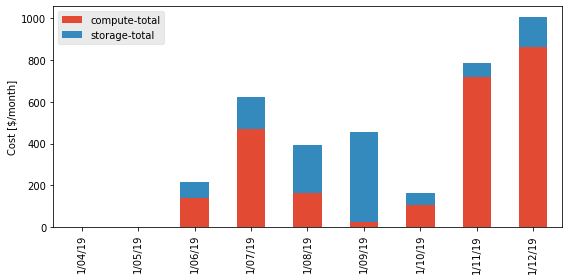

In [13]:
#  plot by component, plot by compute or storage
f, ax = plt.subplots(ncols=1, figsize=(8, 4), sharey=True)
plt.style.use('ggplot')
comps_only = component_per_month.drop(['compute-total', 'total', 'storage-total'], axis=1)

component_per_month.loc[:, ['compute-total', 'storage-total']].plot(kind='bar', ax=ax, stacked=True)
#comps_only.plot(kind='bar', ax=a[1], stacked=True)

ax.grid(False)
ax.set_facecolor('white')
ax.set_xlabel('')
ax.set_ylabel('Cost [$/month]')
plt.tight_layout()
    
f.savefig('/Users/adam/git/adgefficiency.github.io/assets/world-models/aws.png')

In [14]:
out = component_per_month.sum().to_frame()
out.columns = ['Cost [$]']
print(out.round(0))
print(out.round(0).to_markdown())

                     Cost [$]
controller             1506.0
vae-and-memory          602.0
data                     95.0
sample-latent-stats     255.0
misc                     25.0
compute-total          2485.0
s3                       54.0
ebs                    1108.0
storage-total          1162.0
total                  3648.0
|                     |   Cost [$] |
|:--------------------|-----------:|
| controller          |       1506 |
| vae-and-memory      |        602 |
| data                |         95 |
| sample-latent-stats |        255 |
| misc                |         25 |
| compute-total       |       2485 |
| s3                  |         54 |
| ebs                 |       1108 |
| storage-total       |       1162 |
| total               |       3648 |
